# MinHash signatures are fun!

## Utility functions

In [1]:
%matplotlib inline
import numpy
import scipy
import pylab
import scipy.cluster.hierarchy as sch

In [2]:
def load_matrix_and_labels(basefile):
    D = numpy.load(open(basefile, 'rb'))
    labeltext = [ x.strip() for x in open(basefile + '.labels.txt') ]
    return (D, labeltext)

def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True):
    if show_labels:
        show_indices=True
    D = numpy.array(D, copy=True)

    fig = pylab.figure(figsize=(11,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])

    # plot denderogram
    Y = sch.linkage(D, method='single') # centroid  
    
    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [ str(i) for i in range(len(labeltext)) ]
                        
    Z1 = sch.dendrogram(Y, orientation='right', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart,0.1, width,0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=1)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.                                                            
    axcolor = fig.add_axes([scale_xstart,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    
    # print labels, if not shown
    if not show_labels:
        for i, label in enumerate(labeltext):
            print('%d\t%s' % (i, label))

    return fig

## Error trimming helps

Conclusion: removing low-abundance k-mers from raw reads yields better clusters.

In [3]:
!../sourmash compare SRR2*.sig -o trim.npy > /dev/null && echo success || echo fail

success


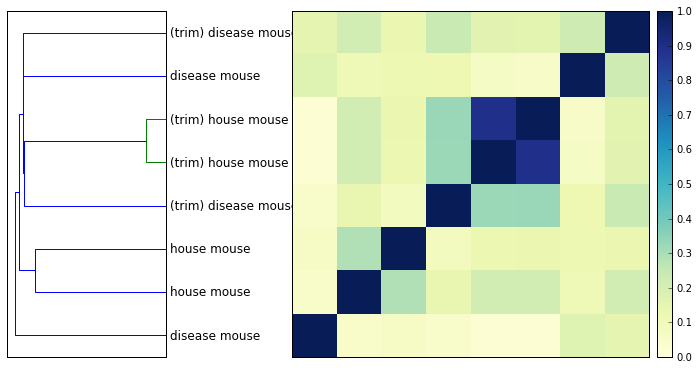

In [4]:
D_filename = 'trim.npy'

D, labeltext = load_matrix_and_labels(D_filename)

# relabel the trimmed ones as 'trim' - they're the ones with trim in the filename ;)
for i in range(len(labeltext)):
    if i % 2:
        labeltext[i] = '(trim) '+ labeltext[i]
_ = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-trimming.png')

In [5]:
print(labeltext)

['house mouse', '(trim) house mouse', 'house mouse', '(trim) house mouse', 'disease mouse', '(trim) disease mouse', 'disease mouse', '(trim) disease mouse']


## Calculating distance matrices for first 1m reads (yeast/mouse data)

Conclusion: data sets group by species after only 1m reads.

In [6]:
!../sourmash compare *.sig.1000000 -o dist-1m.npy > /dev/null && echo success || echo fail

success


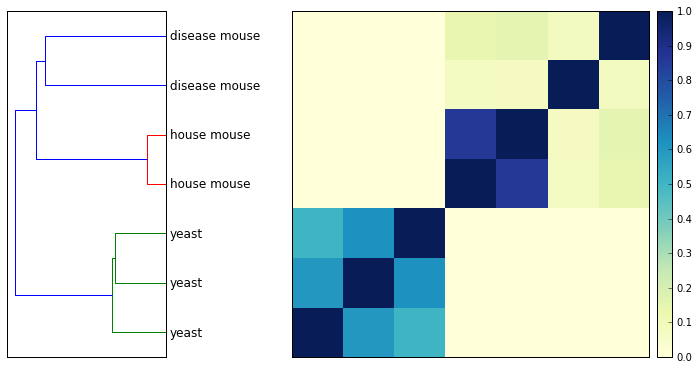

In [7]:
D_filename = 'dist-1m.npy'

D, labeltext = load_matrix_and_labels(D_filename)
_ = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-dist-1m.png')

## Computing distance matrices for different subsets of the same data

Conclusion: many different subsets of the data all compare at ~70%.

In [8]:
!../sourmash compare subset/*.sig -k 31 -o subset-1m.npy > /dev/null && echo success || echo fail

success


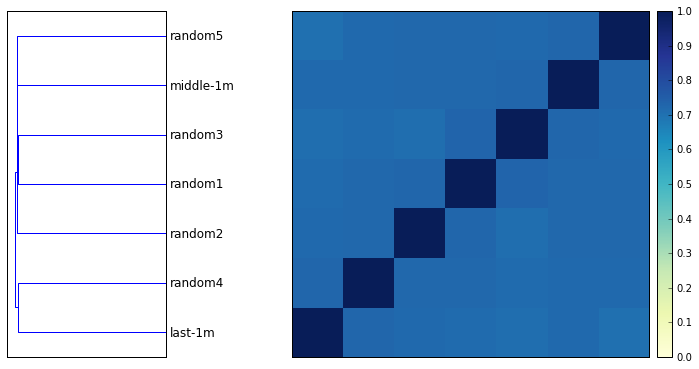

In [9]:
D_filename = 'subset-1m.npy'

D, labeltext = load_matrix_and_labels(D_filename)
_ = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-samples.png')

## Comparing 200+ echinoderm data sets

Conclusion: echinoderm data sets cluster almost entirely by species, with little to no cross-species similarity.

In [10]:
!../sourmash compare ../urchin/*.sig -o urchin.npy > /dev/null && echo success || echo fail

success


In [11]:
%%capture
D_filename = 'urchin.npy'

D, labeltext = load_matrix_and_labels(D_filename)
fig = plot_composite_matrix(D, labeltext, show_labels=False, show_indices=False)
pylab.savefig('sourmash-urchin.png')

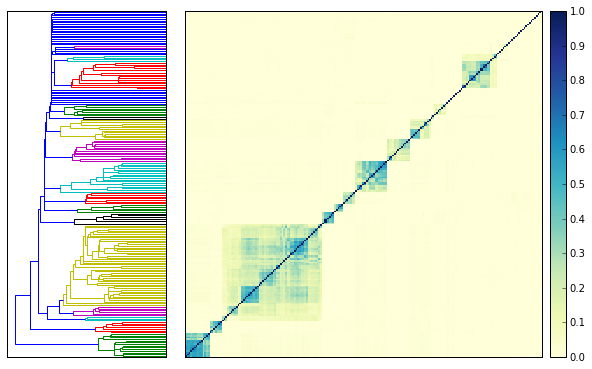

In [12]:
fig

## Comparing bat stars

Conclusion: Patiria asterina and Patiria pectinifera group together, agreeing with [recent reclassifications](https://en.wikipedia.org/wiki/Bat_star#Classification) (ht Dan Rokhsar).

In [13]:
!../sourmash compare ../urchin/miniata*.sig ../urchin/pectinifera*.sig -o patiria.npy > /dev/null \
    && echo success || echo fail


success


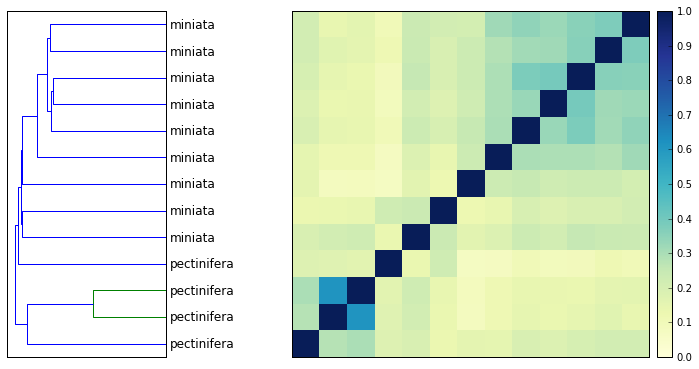

In [14]:
D_filename = 'patiria.npy'

D, labeltext = load_matrix_and_labels(D_filename)
fig = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-patiria.png')

## classifying signatures

Using 'sourmash condense', you can build species- or clade-specific signatures.

In [15]:
!../sourmash search ../urchin/variegatus-SRR1139214.sig ../species/*.sig

# running sourmash subcommand: search
loading signatures from 3 files
1 matches:
	 echinoderms 	 0.328 	 ../species/echinoderms.sig


In [16]:
!../sourmash search ../urchin/purpuratus-SRR1012313.sig ../species/*.sig

# running sourmash subcommand: search
loading signatures from 3 files
2 matches:
	 purp 	 0.72 	 ../species/s_purp.sig
	 echinoderms 	 0.514 	 ../species/echinoderms.sig
